In [1]:
import json, re
import seaborn as sns
import numpy as np
import pandas as pd
import pickle

from vllm import LLM, SamplingParams
from collections import defaultdict
from tqdm import tqdm

/home/cmu/miniconda3/envs/test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 05-13 02:13:00 [__init__.py:239] Automatically detected platform cuda.


2025-05-13 02:13:01,435	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


### Compute score

In [2]:
def extract_numbers_and_target(prompt):
    numbers_match = re.search(r'\[(\d+(?:,\s*\d+)*)\]', prompt)
    numbers = list(map(int, numbers_match.group(1).split(','))) if numbers_match else []

    # Extract the target number
    target_match = re.search(r'equals\s+(\d+)', prompt)
    target = int(target_match.group(1)) if target_match else None
    return numbers, target


def extract_solution(solution_str):
    """Extract the equation from the solution string."""
    # # Remove everything before the first "Assistant:"
    # if "Assistant:" in solution_str:
    #     solution_str = solution_str.split("Assistant:", 1)[1]
    # elif "<|im_start|>assistant" in solution_str:
    #     solution_str = solution_str.split("<|im_start|>assistant", 1)[1]
    # else:
    #     return None
    solution_str = solution_str.split('\n')[-1]

    answer_pattern = r'(.*?)</answer>'
    match = re.finditer(answer_pattern, solution_str)
    matches = list(match)
    if matches:
        final_answer = matches[-1].group(1).strip()
    else:
        final_answer = None
    return final_answer


def validate_equation(equation_str, available_numbers):
    """Validate that equation only uses available numbers and each number once."""
    try:
        # Extract all numbers from the equation
        numbers_in_eq = [int(n) for n in re.findall(r'\d+', equation_str)]
        
        # Check if all numbers in equation are available
        available_numbers = sorted(available_numbers)
        numbers_in_eq = sorted(numbers_in_eq)
        
        # Each number should be used exactly once
        return numbers_in_eq == available_numbers
    except:
        return False


def evaluate_equation(equation_str):
    """Safely evaluate the arithmetic equation using eval() with precautions."""
    try:
        # Define a regex pattern that only allows numbers, operators, parentheses, and whitespace
        allowed_pattern = r'^[\d+\-*/().\s]+$'
        if not re.match(allowed_pattern, equation_str):
            raise ValueError("Invalid characters in equation.")

        # Evaluate the equation with restricted globals and locals
        result = eval(equation_str, {"__builtins__": None}, {})
        return result
    except Exception as e:
        return None


def compute_score(input_str, solution_str, format_score=0, score=1):
    """The scoring function for countdown task.
    
    Args:
        solution_str: the solution text
        ground_truth: dictionary containing target number and available numbers
        method: the method to extract the solution
        format_score: the score for correct format but wrong answer
        score: the score for the correct answer
    """
    numbers, target = extract_numbers_and_target(input_str)
    equation = extract_solution(solution_str=solution_str)
    do_print = False

    if equation is None:
        if do_print:
            print(f"No equation found")
        return 0
    
    # Validate equation uses correct numbers
    if not validate_equation(equation, numbers):
        if do_print:
            print(f"Invalid equation")
        return format_score
        
    # Evaluate equation
    try:
        result = evaluate_equation(equation)
        if result is None:
            if do_print:
                print(f"Could not evaluate equation")
            return format_score
            
        if abs(result - target) < 1e-5:  # Account for floating point precision
            if do_print:
                print(f"Correct equation: {equation} = {result}")
            return score
        else:
            if do_print:
                print(f"Wrong result: equation = {result}, target = {target}")
            return format_score
    except:
        if do_print:
            print(f"Error evaluating equation")
        return format_score 

### Load model and generate rollouts

In [13]:
llm = LLM(model="/home/cmu/countdown-curriculum/checkpoints/normal/global_step_72/hf")

INFO 05-13 02:14:47 [config.py:689] This model supports multiple tasks: {'classify', 'score', 'embed', 'generate', 'reward'}. Defaulting to 'generate'.
INFO 05-13 02:14:47 [config.py:1901] Chunked prefill is enabled with max_num_batched_tokens=16384.
INFO 05-13 02:14:48 [core.py:61] Initializing a V1 LLM engine (v0.8.4) with config: model='/home/cmu/countdown-curriculum/checkpoints/normal/global_step_72/hf', speculative_config=None, tokenizer='/home/cmu/countdown-curriculum/checkpoints/normal/global_step_72/hf', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=131072, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='auto', reasoning_backend=None

: 

In [22]:
df = pd.read_parquet('/home/cmu/countdown-curriculum/data/countdown/test-5-5.parquet')
prompts = []
for i, row in df.iterrows():
    prompts.append(row['prompt'][0]['content'])

In [23]:
completions = llm.generate(prompts=prompts, sampling_params=SamplingParams(n=16, temperature=0.6, top_p=0.95, max_tokens=2048))

Processed prompts: 100%|██████████| 2560/2560 [03:05<00:00, 13.82it/s, est. speed input: 1961.74 toks/s, output: 12683.90 toks/s] 


In [ ]:
with open('/home/cmu/countdown-curriculum/checkpoints/normal/72_rollouts_16.pkl', 'wb') as f:
    pickle.dump(completions, f)

In [3]:
with open('/home/cmu/countdown-curriculum/checkpoints/normal/72_rollouts_16.pkl', 'rb') as f:
    rollouts = pickle.load(f)

### Visualize # of attempts

In [4]:
attempts = []
for rollout in rollouts:
    for output in rollout.outputs:
        attempts.append(len(output.text.split('\n\n')))

<Axes: ylabel='Count'>

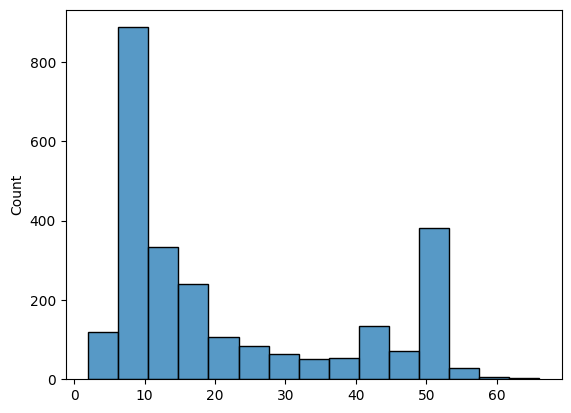

In [5]:
sns.histplot(attempts)

### Rollout and compute pass@1

In [6]:
def compute_pass_at_k(n, c, k):
    if n - c < k:
        return 1.0
    
    return 1.0 - np.prod(1.0 - k / np.arange(n - c + 1, n + 1))

In [7]:
def extract_equations(attempt):
    equation_line_pattern = re.compile(r'^([\d\s\+\-\*/=]+)')

    equations = []
    for line in attempt.strip().split('\n'):
        line = line.strip()
        match = equation_line_pattern.match(line)
        if match:
            cleaned_eq = match.group(1).strip()
            equations.append(cleaned_eq)
        elif any(op in line for op in '+-*/='):  # fallback: manually extract left side before any annotation
            cleaned_eq = re.split(r'\s*\(.*?\)', line)[0].strip()
            equations.append(cleaned_eq)

    return equations

In [ ]:
attempts_to_k_to_pass_at_k = defaultdict(lambda: defaultdict(list))
R = 8

for attempts_budget_per_rollout in [2, 4, 8, 16]:
    
    for problem in tqdm(rollouts, total=len(rollouts)):
        n = len(problem.outputs) * R
        c = 0
        prefixes = []
        
        for output in problem.outputs:
            attempts = output.text.split('\n\n')

            attempts_used = 0
            budget_index = len(attempts)
            for l, attempt in enumerate(attempts):
                if len(extract_equations(attempt)) > 0:
                    attempts_used += 1
                    if attempts_used == attempts_budget_per_rollout:
                        budget_index = l + 1
                        break
            
            prefixes.append(problem.prompt + '\n\n'.join(attempts[:budget_index]) + "\n</think>\n<answer>")
        
        completions = llm.generate(prompts=prefixes, sampling_params=SamplingParams(n=R, temperature=0.6, top_p=0.95, max_tokens=100), use_tqdm=False)

        assert len(completions) == 16
        for completion in completions:

            assert len(completion.outputs) == R
            for output in completion.outputs:
                c += compute_score(problem.prompt, output.text, format_score=0, score=1)
        
        for k in [1, 2, 4, 8, 16]:
            attempts_to_k_to_pass_at_k[attempts_budget_per_rollout][k].append(compute_pass_at_k(n, c, k))


100%|██████████| 160/160 [01:47<00:00,  1.49it/s]


In [12]:
for B in [16, 32]:
    for attempts_budget_per_rollout in [2, 4, 8, 16]:
        k = B // attempts_budget_per_rollout
        pass_at_k = np.mean(budget_to_pass_at_k[B][attempts_budget_per_rollout])
        print(f"pass@{k} at {attempts_budget_per_rollout} attempts: {pass_at_k:.4f}")

pass@8 at 2 attempts: 0.0414
pass@4 at 4 attempts: 0.1755
pass@2 at 8 attempts: 0.4134
pass@1 at 16 attempts: 0.4885
pass@16 at 2 attempts: 0.0789
pass@8 at 4 attempts: 0.2447
pass@4 at 8 attempts: 0.5075
pass@2 at 16 attempts: 0.6136


### Plot

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from rliable import plot_utils
plt.rcParams['text.usetex'] = False #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = r'\usepackage{sansmath} \sansmath' #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = ['Helveta Nue'] # Choose a nice font here
sns.set_style("whitegrid")

COLORS = ['#BBCC33', '#77AADD', '#44BB99',
           '#EEDD88', '#EE8866', '#FFAABB',
          '#99DDFF', '#44BB99', '#AAAA00',
          '#DDDDDD']
palette = sns.set_palette(COLORS)

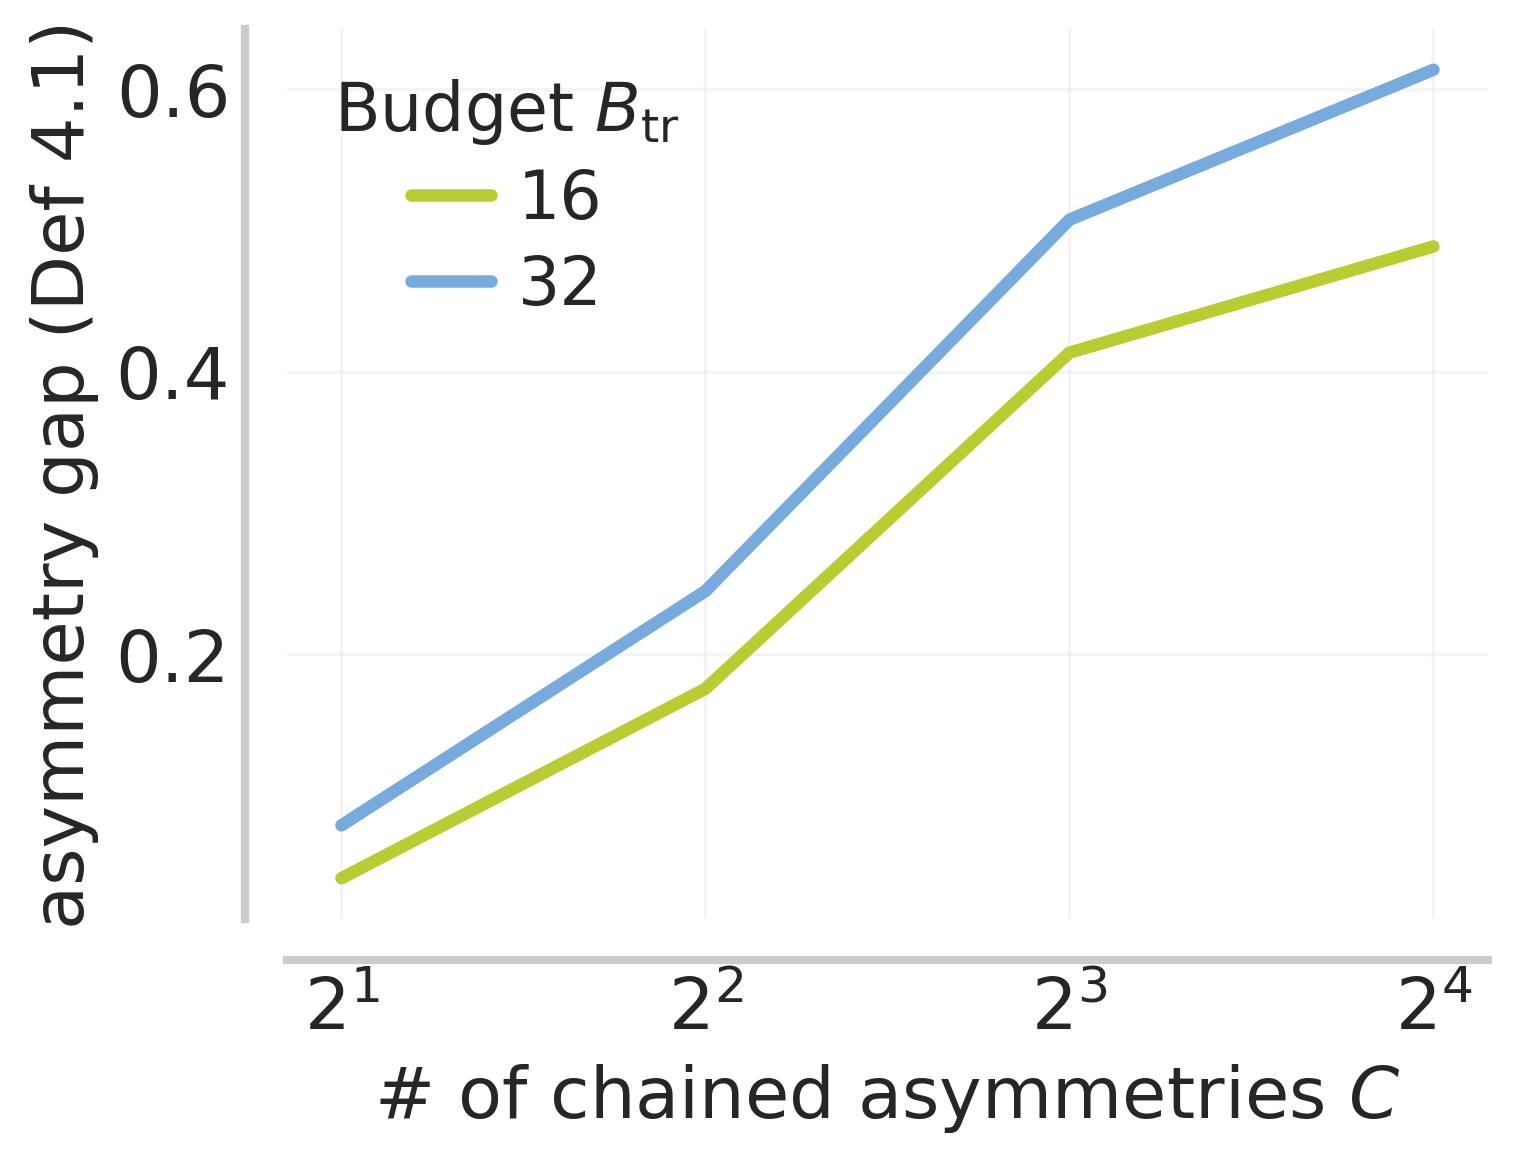

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=300)
fig.set_size_inches(496.0/192*2, 369.6/192*2)

for i, B in enumerate([16, 32]):

    pass_at_k = []
    for attempts_budget_per_rollout in [2, 4, 8, 16]:
        k = B // attempts_budget_per_rollout
        pass_at_k.append(np.mean(budget_to_pass_at_k[B][attempts_budget_per_rollout]))
    
    sns.lineplot(x=[1, 2, 3, 4], y=pass_at_k, ax=ax, linewidth=3, markersize=8, color=COLORS[i], label=f'{B}', linestyle='-')

plt.xticks(ticks=[i for i in range(1, 5)], labels=[f"$2^{{{i}}}$" for i in range(1, 5)])

plot_utils._annotate_and_decorate_axis(ax,
                                        xlabel=r'# of chained asymmetries $C$',
                                        # ylabel=r'pass@($B/C$)',
                                        ylabel=r'asymmetry gap (Def 4.1)',
                                        labelsize='xx-large',
                                        ticklabelsize='xx-large',
                                        grid_alpha=0.2,
                                        legend=True)

ax.legend(
        title=r"Budget $B_\mathrm{tr}$",
        title_fontsize=16,          # Title font size
        prop={'size': 16},         # Slightly smaller font
        ncol=1,                    # Keep 1 column
        frameon=False,             # No box
        handlelength=1.2,          # Shrink line length
        handletextpad=0.4,         # Shrink space between marker and text
        borderpad=0.2,             # Shrink border padding inside legend box
        labelspacing=0.3,          # Reduce vertical space between entries
        loc="upper left",                # Optional: auto position
        markerscale=0.8,            # Shrink marker size
        # bbox_to_anchor=(-0.1, 1)
    )

plt.savefig("plots/asymmetry_gap.pdf", bbox_inches='tight',pad_inches=0)
plt.show()